In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

In [2]:
from math import log, exp, inf, sqrt, gamma
from scipy import optimize
import scipy.spatial.distance as sci
import scipy.special as spec
import networkx as nx

from sklearn import datasets
from sklearn import metrics

import itertools
from itertools import cycle
from collections import defaultdict
from heapq import *

In [3]:
def distance_matrix(X):
    """Compute the distance matrix of the data X"""
    
    return sci.squareform(sci.pdist(X, 'euclidean'))

def get_lambda_hash(h, d, L_T):
    """Extract the values computed by get_lambda_table()"""
    
    h_ratio = 1.95
    return np.take(L_T, np.minimum((d / h / h_ratio * (len(L_T) - 1) ).astype(int), (len(L_T) - 1)))

def get_lambda_table(n, m):
    """Compute the ratio of the volumes of the intersection and the union of two balls.
    This value depends on the ratio d/h,
    where d is the distance between centers of balls
    and h is the radius of these balls.
    The ratio is computed over small greed on [0,1]"""
    
    h_ratio = 1.95
    x = np.linspace(0 + 1./m, h_ratio + 1./m, m+1)
    a = spec.betainc((n+1.) / 2, 0.5, 1. - (x/2.)**2)
    return a / (2-a)

def init_weights(dist_matrix, H, n_0, discrete=False):
    """Initialize the matrix of weights_"""
    
    dmatrix = np.sort(dist_matrix, axis=1)
    v = dmatrix[:, n_0]
    n = np.size(dist_matrix,0)
    
    if discrete == True:
        for i in range(n):
            for j in range(n):
                if dmatrix[i, j] != 0:
                    v[i] = dmatrix[i, j + n_0 - 1]
                    break
        
    weights = np.zeros((n,n))
    for i in range(n):
        h_closest = H[-1]
        for h in H:
            if h >= v[i]:
                h_closest = h
                break
        weights[i, :] = 1 * (dist_matrix[i,:] <= h_closest) 
    weights = np.maximum(weights, weights.T)
    return weights
  
def KL_init():
    """Compute the test statistics on a small greed over cube [0,1]x[0,1]
    to reduce computational costs"""
    m = 2000
    e1 = np.linspace(0, 1, m + 1)
    e = np.repeat([e1], m + 1, axis=0)
    q = e.T
    with np.errstate(divide='ignore', invalid='ignore'):
        KL = (-1) ** (e > q) * (e-q) * np.log((e * (1. - q) / q / (1. - e)))

    KL = np.nan_to_num(KL)
    return KL

def get_h_intervals(dist_matrix, n_0, discrete=False, speed=1.5):
    """Compute the sequence of radii h_k for all steps"""
      
    h_ratio = 1.95
    dist_matrix = np.sort(dist_matrix)
    n = np.size(dist_matrix, 0)
    ### Idea
    aa = 2 ** 0.5

    h_final = [np.min(dist_matrix[:, n_0-1])]
    #for discrete
    if discrete == True:
        h_start = np.min(dist_matrix[:, int(n_0 * aa)])
        if h_start == 0:
            h_final = [np.min(dist_matrix[dist_matrix > 0])]
        else:
            h_final = [h_start]
    
    h_max = np.max(dist_matrix)
    #print h_max
    while(h_final[-1] != h_max):
        h = h_final[-1]
        h_candidates_ind = np.argmax(dist_matrix > h, axis=1)
        argmax_to_check = dist_matrix[range(n), h_candidates_ind] > h
        h_candidates_ind -= 1
        h_candidates_ind = h_candidates_ind.clip(min=n_0)
        h_candidates_ind = np.maximum(((h_candidates_ind * aa ** speed).clip(max=n-1)).astype(int), h_candidates_ind+1)
        argmax_to_check = argmax_to_check * (h_candidates_ind < n-1)
        F = dist_matrix[np.arange(n)[argmax_to_check], h_candidates_ind[argmax_to_check]]
        if len(F) == 0:
            h_next=h_max
        else:  
            h_next = np.min(F)
        h_final.append(min(h_next, h * h_ratio))
    
#     print('number of steps:', len(h_final))
    a = [h_final[0]]
    for i in range(len(h_final)-1):
        if h_final[i+1] - h_final[i] != 0:
            a.append(h_final[i+1])
    if a[0] == 0:
        del a[0]
    for i in range(4):
        a.append(a[-1]* 1.5)
    return a, dist_matrix



def init(X, dist_matrix, n_neigh=-1, dim=-1, discrete=False, speed=1.5):
    """initialization step for all variables"""
    if dist_matrix is None:
        dist_matrix = distance_matrix(X)
    n = np.size(dist_matrix, 0)
    if X is None:
        dim = 2
    if dim == -1:
        if np.size(X, 1) > 7:
            dim = 2
        else: 
            dim = np.size(X, 1)
    if n_neigh == -1:
        n_neigh = max(6, min(2 * dim + 2, 0.1 * n))
        #if dim == -1:
        #    n_0 = 2 * np.size(X, 1) + 2
        #else:
        #    n_0 = 2 *s dim + 2
    L_T = get_lambda_table(dim, 10000)
    H, dist_ordered = get_h_intervals(dist_matrix, n_neigh, discrete, speed)
    v = dist_ordered[:, n_neigh-1].clip(min=H[0])
    weights = init_weights(dist_matrix, H, n_neigh, discrete) 
    T = np.zeros((n, n))
    KL = KL_init()
    return L_T, dist_matrix, H, v, weights, T, KL


def cluster_step(l, weights, v, n, k, L_T, T, KL, dist_matrix, H):
    """ Make one iteration of the AWC algorithm"""
    
    neighbour_numbers = np.sum(weights * (dist_matrix <= H[k-1]), axis = 1) - 1
    D2 = dist_matrix <= H[k-1]
    np.fill_diagonal(D2, False)
    P =  D2 * weights
    
    max_dist = np.max(dist_matrix, axis=1)
    
    t_1 = (neighbour_numbers[np.newaxis, :] - P).T
    t_12 = np.inner(P, P)
    t_12x = np.inner(P, D2)
    gg1 = (t_1 == t_12x) * (t_12 < 0.5 * t_12x)
    #gg2 = (t_1.T == t_12x.T) * (t_12 < 0.5 * t_12x.T)
    
    t_1 = t_1 - t_12x + t_12
    q = get_lambda_hash(H[k-1], dist_matrix, L_T)
    #E = (max_dist[i] < H[k-1]) * ( max_dist[i+1:] < H[k-1])
    #q[E] = 1. / get_lambda_hash(np.maximum(max_dist[i], max_dist[i+1:][E]), dist_matrix[i, i+1:][E], L_T)
    
    E = max_dist < H[k-1]
    F = np.repeat([max_dist], n, axis = 0)
    R = np.maximum(F.T, F)
    q[E, :][:, E] = get_lambda_hash(R[E, :][:, E], dist_matrix[E, :][:, E], L_T)
    
    t = t_1 + t_1.T - t_12
    with np.errstate(invalid='ignore'):
        e = t_12 / t
        aa = e >= 0.95
    e[t == 0] = 0
    e = e.clip(min=0.05, max=0.9)
    q = q.clip(min=0.05, max=0.9)
    bb = e <= 0.05
    e *= 2000
    q *= 2000
    
    e = e.astype(int)
    q = q.astype(int)
    
    T = t * KL[q, e]
    T[np.logical_or(bb, t_12 == 0)] = np.nan
    T[aa] = l
    sum_v = v > H[k-1]
    T[sum_v, :] = float("inf")
    T[:, sum_v] = float("inf")
    T[np.logical_or(gg1, gg1.T)] = np.nan
    #T[gg2] = np.nan
    
    I = (dist_matrix <= H[k]) * (dist_matrix > 0) * (T != float("inf")) * (np.isnan(T) == False)
    weights[I] = 1 * (T[I] <= l)
    weights[np.isnan(T)] = 0
    np.fill_diagonal(weights, 1)
    return

def connect_outliers(weights, n_outliers, dist_matrix, n):
    """ Connect outliers to their nearest clusters_"""
    
    N = np.sum(weights, axis=1)
    outliers = N <= n_outliers
    distance_order = np.argsort(dist_matrix, axis=1)
    for i in range(n):
        if outliers[i] == True:
            for j in range(1, n):
                if outliers[distance_order[i,j]] == False:
                    w = weights[j, :]
                    w[i] = 1
                    weights[i, :] = w
                    weights[:, i] = w
                    break
    #print 'kkkkkk'
    return weights
    N = np.reshape(np.sum(weights, axis=1), (-1,))
    outliers = np.where(N <= n_outliers)[0]
    distance_order = np.argsort(dist_matrix, axis=1)
    for i in outliers:
            for j in range(1, n):
                if j not in outliers[distance_order[i,j]]:
                    w = weights[j, :]
                    weights[i, :] = w
                    weights[:, i] = w
                    break
    return weights

def clustering_from_weights(weights):
    """Extract cluster structure from the weight matrix represented as list, 
    which contains for each cluster list of indexes of points in this cluster.
    
    Returns
    -------
    clusters_ : list, shape (n_clusters,)
       Cluster structure of the data, i.e. list of clusters, where each cluster 
       is a list of points indexes in that cluster.   
    """
    n = len(weights)
    clusters = []
    adjmatrix = np.zeros((n, n), dtype=np.int8)
    for i in range(n):
        for j in range(n):
            if weights[i, j] >= 0.5:
                adjmatrix[i, j] = 1
    points = range(n)
    while(len(points) != 0):
        neigbohours = np.sum(adjmatrix, axis=1)
        candidates = np.argsort(neigbohours)
        for cluster_generater in reversed(candidates):
            neigbohours_i = neigbohours[adjmatrix[cluster_generater, :] == 1]
            if np.sum(neigbohours_i > (neigbohours[cluster_generater] - 5)) > 0.95 * np.size(neigbohours_i,0):
                break
        all_cliques = ()
        for i in range(len(points)):
            if adjmatrix[cluster_generater, i] == 1:
                all_cliques += tuple([i])
        all_cliques = [all_cliques]
        clusters.append([points[i] for i in range(len(points)) if i in all_cliques[0]])
        adjmatrix = np.delete(adjmatrix, all_cliques[0], 0)
        adjmatrix = np.delete(adjmatrix, all_cliques[0], 1)
        points = [points[i] for i in range(len(points)) if i not in all_cliques[0]]
    
    return clusters

class AWC():
    """Adaptive Weights Clustering

    Parameters
    ----------
    
    n_neigh : int, optional, default: -1
        The number of closest neighbors to be connected on the initialization step.
        If not specified, n_neigh = max(6, min(2 * effective_dim + 2, 0.1 * n_samples))
        
    effective_dim : int, optional, default: -1
        Effective dimension of data X. 
        If not specified, effective_dim = true dimension of the data, 
        in case the true dimension is less than 7, otherwise 2.
    
    n_outliers : int, optional, default: 0
        Minimum number of points each cluster must contain.
        Points from clusters with smaller size will be connected to the closest cluster.
    
    discrete : boolean, optional, default: False
        Specifies if data X consists of only discrete values.
        
    speed : int, optional, default: 1.5
        Controls the number of iterations.
        Increase of the speed parameter decreases the number of steps.
        
    Attributes
    ----------
    dmatrix : array, shape = [n_samples, n_n_samples]
        Distance matrix.
        
    clusters_ : list of lists
        Cluster structure of data X i.e. list of clusters, where each cluster 
       is a list of points indexes in that cluster. 
    
    weights_ : numpy array, shape = [n_samples, n_samples]
        Weight matrix computed by awc.
    
    labels_ : array, shape = [n_samples,]
        Labels of each point
    
    """
    
    def __init__(self, n_neigh=-1, effective_dim=-1, n_outliers=0, discrete=False, speed=1.5):
        self.n_neigh = n_neigh
        self.effective_dim = effective_dim
        self.n_outliers = n_outliers
        self.discrete = discrete
        self.clusters_ = None
        self.speed = speed
    
    def awc(self, l, X=None, dmatrix=None):
        """Recover cluster structure of data X.
        
        Parameters
        ----------
        l : int
            The lambda parameter.
        
        X : array, shape (n_samples, n_features), optional, default: None 
            Input data. 
            awc works with distance matrix. 
            User must specify X or dmatrix.
            From X Euclidean distance matrix is computed and passed to awc.
            No need to specify X, if dmatrix is specified. 
        
        dmatrix : array, shape (n_samples, n_n_samples), optional, default: None
            Distance matrix. If not specified, then X must be specified, from which 
            Euclidean distance matrix is computed.
            
        
        Returns
        -------
        weights_ : array, shape (n_samples, n_samples)
           Final weights from which the cluster structure can be extracted. 
        """
        
        if X is None and dmatrix is None:
            raise ValueError("X and dmatrix can't be both None.")
        
        L_T, self.dmatrix, H, v, self.weights_, T, KL = init(X, dmatrix, self.n_neigh, self.effective_dim, self.discrete, self.speed)
        n = np.size(self.dmatrix, 0)
        for k in range(1, len(H)):
            #print 'step k=', k, '/', len(H)-1
            cluster_step(l, self.weights_, v, n, k, L_T, T, KL, self.dmatrix, H)
        if self.n_outliers >= 1:
            self.weights_ = connect_outliers(self.weights_, self.n_outliers, self.dmatrix, n)
        return self.weights_
    
    def get_clusters(self):
        """Extract cluster structure as list, 
        which contains for each cluster list of indexes of points in this cluster.
        
        Returns
        -------
        clusters_ : list
           Cluster structure of the data, i.e. list of clusters, where each cluster 
           is a list of points indexes in that cluster.   
        """
        if self.clusters_ == None:
            self.clusters_ = clustering_from_weights(self.weights_)
        
        return self.clusters_
        
    def get_labels(self):
        """Extract labels of points from cluster structure.
        
        Returns
        -------
        labels_ : array, shape (n_samples,)
           Labels of each point.  
        """
        if self.clusters_ == None:
            self.get_clusters()
        Y = np.zeros(len(self.weights_))
        for k in range(len(self.clusters_)):
            Y[self.clusters_[k]] = k
        self.labels = Y
        return self.labels
    
    def plot_sum_of_weights(self, lambda_interval, X=None, dmatrix=None):
        """Plot the sum of computed weights for lambda parameters from the given interval.
        
        Parameters
        ----------
            
        lambda_interval : list
            Lambda parameters for which sum of weights will be computed.
            
        X : array, shape (n_samples, n_features), optional, default: None 
            Input data. 
            No need to specify X, if dmatrix is specified. 
        
        dmatrix : array, shape (n_samples, n_n_samples), optional, default: None
            Distance matrix. If not specified, then Euclidean distance matrix is computed from X.
        
        Returns
        -------
        weights_computed : array, shape (n_samples, n_samples)
           Computed weights for each lambda parameter from the given interval. 
        """
        weights_computed = []
        for l in lambda_interval:
            weights = self.awc(l, X, dmatrix)
            weights_computed.append(weights)
        
        sorting_order = np.argsort(lambda_interval)
        lambda_interval = np.asarray(lambda_interval)
        weights_summed = [np.sum(weights_computed[i]) * 1. / (len(X)**2) for i in range(len(lambda_interval))]
        weights_summed = np.asarray(weights_summed)
        
        plt.plot(lambda_interval[sorting_order], weights_summed[sorting_order], '-r', label=r'$\sum w_{ij}$',linewidth=3)

        plt.legend(loc=2, fontsize=16)
        plt.xlabel(r'$\lambda$', size=20)
        #plt.ylabel(r'$\sum of weights$', size=17)
        #plt.title('Sum of Weights')
        plt.grid(b=True, which='major', color='k', linestyle='--')
        #plt.grid(b=True, which='minor', color='r', linestyle='-', linewidth=0)
        plt.xticks(np.arange(min(lambda_interval[sorting_order]), max(lambda_interval[sorting_order])+1, 2.0))
        plt.show()
        return weights_computed

In [4]:
class ARFLayout:
    def __init__(self, vertexCount, n):
        self.adjacencyMatrix = np.zeros((vertexCount, vertexCount))
        self.a = 3
        self.attraction = 0.2
        self.b = 8
        self.deltaT = 2
        self.epsilon = 0.2
        self.forceCutoff = 7
        self.threshold = 10
        self.updatesPerFrame = 1
        self.randOnce = True
        self.unchangedCount = 0
        self.coords = []
        
        self.converged = False
        self.change = 0.0
        self.iterations = 0
        self.sensitivity = 0
        
        self.n = n

    def distance(self, first, second):
         return math.sqrt(sum([(first[i] - second[i]) ** 2 for i in range(len(first))]))

    def createGraph(self, edges):
        for i in range(len(edges)):
            self.adjacencyMatrix[edges[i][0], edges[i][1]] = 1
            self.adjacencyMatrix[edges[i][1], edges[i][0]] = 1

    def getDegree(self, vertex):
        deg = 0
        for i in range(self.adjacencyMatrix.shape[0]):
            deg += self.adjacencyMatrix[vertex, i]
        return deg

    def isAdjacent(self, vertex1, vertex2):
        return self.adjacencyMatrix[vertex1, vertex2] == 1

    def randomizePositions(self):
        for i in range(self.adjacencyMatrix.shape[0]):
            radius = 300 * random.random()
            
            coord = []
            
            alpha = 2 * math.pi * np.random.rand(self.n-1)
            for i in range(0, self.n):
                x = 5
                if i > 0:
                    x *= math.cos(alpha[i-1])
                for j in range(i, self.n-1):
                    x *= math.sin(alpha[j])
                x += 300
                coord.append(x)
                
            self.coords.append(coord)
#             alpha = 2 * math.pi * random.random()
#             beta = 2 * math.pi * random.random()
#             self.coords.append([radius * math.cos(alpha) * math.sin(beta) + 300, radius * math.sin(alpha) * math.sin(beta) + 300, radius * math.cos(beta) + 300])

    def initAlgorithm(self, size):
        self.converged = False
        self.change = 1e20
        self.randOnce = True
        self.sensitivity = 1
        self.unchangedCount = 0
        self.iterations = 0
        self.threshold = self.epsilon * size
        
        self.randomizePositions()

    def getForceForNode(self, vertex):
        numNodes = self.adjacencyMatrix.shape[0]
        mDot = [0 for i in range(self.n)]

        if all(np.array(self.coords[vertex]) == 0):
            return mDot

        for i in range(numNodes):
            if i == vertex:
                continue

            temp = []
            for j in range(self.n):
                temp.append(self.coords[i][j] - self.coords[vertex][j])

            multiplier = self.a if self.isAdjacent(i, vertex) else 1
            multiplier *= self.attraction / math.sqrt(numNodes)
            mDot = [mDot[j] + temp[j] * multiplier for j in range(self.n)]

            multiplier = 1 / math.sqrt(sum([temp[j] ** 2 for j in range(self.n)]))
            mDot = [mDot[j] - temp[j] * multiplier * self.b for j in range(self.n)]

        dist = self.distance(mDot, [0 for j in range(self.n)])
        if dist > self.forceCutoff:
            mult = self.forceCutoff / dist
            mDot = [mDot[j] * mult for j in range(self.n)]

        return mDot

    def advancePositions(self):
        c = 0
        nodeCount = self.adjacencyMatrix.shape[0];

        for i in range(nodeCount):
            f = self.getForceForNode(i);

            log = 1 if math.log10(nodeCount) == 0 else math.log10(nodeCount)
            delta = (self.deltaT / log) / pow(self.getDegree(i), 0.4) if self.getDegree(i) > 1 else (self.deltaT / log)

            f = [f[j] * delta for j in range(self.n)]

            self.coords[i] = [self.coords[i][j] + f[j] / self.sensitivity for j in range(self.n)]

            c += sum([abs(f[j]) for j in range(self.n)])

        self.align([100 for j in range(self.n)])
        self.setChange(c)

    def setChange(self, c):
        limit = 5

        if c == self.change:
            self.unchangedCount += 1

            if self.unchangedCount == limit:
                self.unchangedCount = 0
                self.converged = True
        elif c < self.change:
            self.converged = self.change <= self.threshold
            self.unchangedCount = 0
    
        if c > 50000 and self.randOnce:
            self.randomizePositions()
            self.randOnce = False

        self.change = c

    def align(self, xyz0):
        xyz = [1e20 for j in range(self.n)]
        numNodes = self.adjacencyMatrix.shape[0]

        for i in range(numNodes):
            for j in range(self.n):
                xyz[j] = min(xyz[j], self.coords[i][j])

        for i in range(numNodes):
            self.coords[i] = [self.coords[i][j] - xyz[j] + xyz0[j] for j in range(self.n)]

    def layout(self):
        size = self.adjacencyMatrix.shape[0]

        while not self.converged:
            self.advancePositions()
            self.iterations += 1
        
#         self.scaleGraph()

#     def scaleGraph(self):
#         self.align([30 for j in range(self.n)])

#         horisontalFormSize = 984
#         verticalFormSize = 633

#         maxX = -1e20
#         maxY = -1e20
        
#         for c in self.coords:
#             if c[0] > maxX:
#                 maxX = c[0]
#             if c[1] > maxY:
#                 maxY = c[1]

#         if maxX > horisontalFormSize:
#             for i in range(len(self.coords)):
#                 self.coords[i] = [horisontalFormSize * 0.9 * self.coords[i][0] / maxX, self.coords[i][1]]
            
#         if maxY > verticalFormSize:
#             for i in range(len(self.coords)):
#                 self.coords[i] = [self.coords[i][0], verticalFormSize * 0.9 * self.coords[i][1] / maxY]

    def createLayout(self, edges):
        size = self.adjacencyMatrix.shape[0]
        self.createGraph(edges)
        self.initAlgorithm(size)
        self.layout()
        return self.coords

Count of vertices: 114
Count of edges: 985


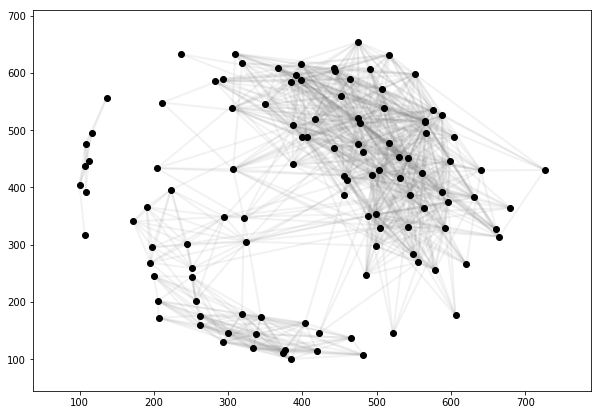

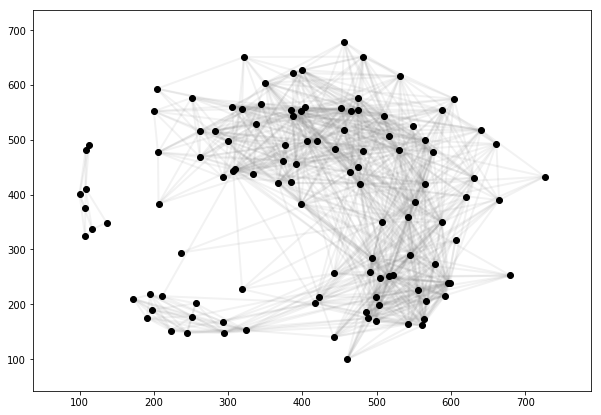

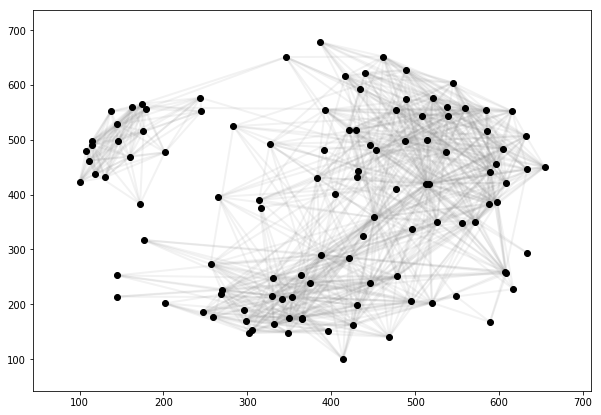

In [18]:
e = (np.genfromtxt(fname="Graph.txt", delimiter=" ", skip_header=1, dtype=int)).tolist()
print("Count of vertices:", np.amax(e)+1)
print("Count of edges:", len(e))
layout = ARFLayout(np.amax(e)+1, 3)
coords = layout.createLayout(e)
for c_ in itertools.combinations(list(range(0, len(coords[0]))), 2):
    fig, ax = plt.subplots(figsize=(10,7))
    for c in coords:
        plt.plot(c[c_[0]], c[c_[1]], 'ko')
    lines = []
    c = []
    for edge in e:
        lines.append([(coords[edge[0]][c_[0]], coords[edge[0]][c_[1]]), (coords[edge[1]][c_[0]], coords[edge[1]][c_[1]])])
        c.append((0.5, 0.5, 0.5, 0.1))
    lc = mc.LineCollection(lines, colors=np.array(c), linewidths=2)
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)

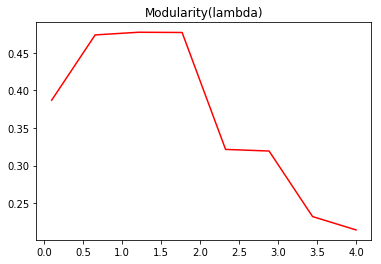

Optimal l: 1.21428571429
–––– TEST ––––


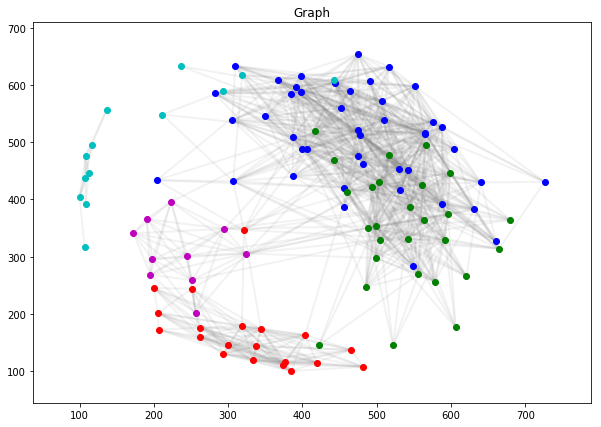

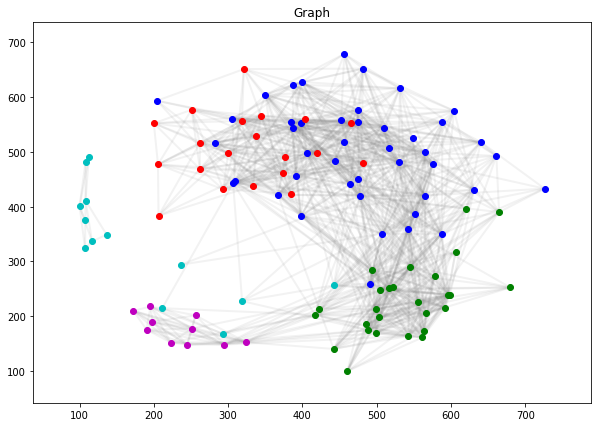

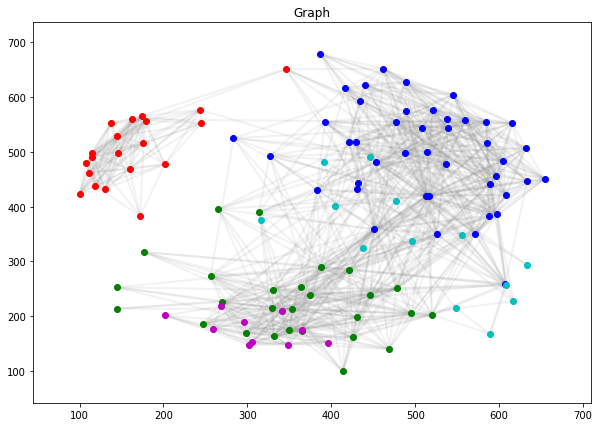

Estimated number of clusters: 5
Modularity: 0.477163029194


In [19]:
def draw(X, labels, name):
    for c_ in itertools.combinations(list(range(0, len(X[0]))), 2):
        n_clusters = len(set(labels))
        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        fig, ax = plt.subplots(figsize=(10,7))
        for k, col in zip(range(n_clusters), colors):
            class_members = labels == k
            plt.plot(X[class_members, c_[0]], X[class_members, c_[1]], col + 'o')
        lines = []
        c = []
        for edge in e:
            lines.append([(coords[edge[0]][c_[0]], coords[edge[0]][c_[1]]), (coords[edge[1]][c_[0]], coords[edge[1]][c_[1]])])
            c.append((0.5, 0.5, 0.5, 0.1))
        lc = mc.LineCollection(lines, colors=np.array(c), linewidths=2)
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)

        plt.title(name)
        plt.show()

        
def delta(c1, c2):
    return int(c1 == c2)


def Q(graph, labels):
    m = np.sum(graph.adjacencyMatrix) / 2
    x = 0
    for i in range(graph.adjacencyMatrix.shape[0]):
        for j in range(graph.adjacencyMatrix.shape[0]):
            if i == j:
                continue
            dd = (graph.getDegree(i) * graph.getDegree(j)) / (2*m)
            x += (graph.adjacencyMatrix[i, j] - dd) * delta(labels[i], labels[j])
    Q = 1/(2*m) * x
    return Q
        
        
def run_graph(l, draw_=False):
    iris = datasets.load_iris()
    X = np.array(coords)
    AWC_object = AWC(speed=1.)
    # lambda_interval = np.linspace(.1, 1, 20)
    # AWC_object.plot_sum_of_weights(lambda_interval, X)
    AWC_object.awc(l, X)
    clusters = AWC_object.get_clusters()
    labels = AWC_object.get_labels()
    if draw_:
        draw(X, labels, 'Graph')
        print('Estimated number of clusters: %d' % len(set(labels)))
    
    return Q(layout, labels)
    
modul = []
for l in np.linspace(0.1, 4, 8).tolist():
    modul.append(run_graph(l))

plt.title("Modularity(lambda)")
plt.plot(np.linspace(0.1, 4, 8), modul, 'r')
plt.show()
opt_l = np.linspace(0.1, 4, 8)[np.argmax(modul)]
print("Optimal l:", opt_l)

print("–––– TEST ––––")
print("Modularity:", run_graph(opt_l, draw_=True))